In [ ]:
#importing libraries
import numpy as np
import scipy.stats as sts
import pandas as pd
import pystan

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#linking notebook to Google Drive folder where the data is uploaded
from google.colab import drive 
drive.mount('/content/gdrive')

#loading csv file
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/cs146-lba-data-1.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Country,Store,Category,AvgRental,Product 1 quantity (kg),Product 1 price,Product 2 quantity (kg),Product 2 price,Product 3 quantity (kg),Product 3 price,Product 1 quantity (kg).1,Product 1 price.1,Product 2 quantity (kg).1,Product 2 price.1,Product 3 quantity (kg).1,Product 3 price.1,Product 1 quantity (kg).2,Product 1 price.2,Product 2 quantity (kg).2,Product 2 price.2,Product 3 quantity (kg).2,Product 3 price.2,Product 1 quantity (kg).3,Product 1 price.3,Product 2 quantity (kg).3,Product 2 price.3,Product 3 quantity (kg).3,Product 3 price.3,Product 1 quantity (kg).4,Product 1 price.4,Product 2 quantity (kg).4,Product 2 price.4,Product 3 quantity (kg).4,Product 3 price.4,Product 1 quantity (kg).5,Product 1 price.5,Product 2 quantity (kg).5,Product 2 price.5,Product 3 quantity (kg).5,Product 3 price.5,Product 1 quantity (liters),Product 1 price.6,Product 2 quantity (liters),Product 2 price.6,Product 3 quantity (liters),Product 3 price.6,Product 1 quantity (kg).6,Product 1 price.7,Product 2 quantity (kg).6,Product 2 price.7,Product 3 quantity (kg).6,Product 3 price.7,Product 1 quantity (count),Product 1 price.8,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,Germany,EDEKA,Mid-range,900,1.0,2.93,2.0,3.22,1.0,1.75,1.0,1.73,1.0,1.73,NaN,NaN,0.4,1.95,0.5,2.24,1.00,2.84,2.0,0.96,2.0,1.05,2.00,1.93,1.0,1.75,1.0,1.26,1.0,1.56,0.25,1.95,0.50,2.83,1.00,4.89,1.0,1.46,1.0,1.05,1.0,1.25,0.25,2.15,0.25,2.14,0.25,2.10,6.0,3.79,6.0,1.75,4.0,1.99,0.312,3.97,0.600,3.87,0.400,2.90
1,Germany,EDEKA,Mid-range,850,1.0,1.95,1.0,2.93,0.8,2.93,1.0,1.73,1.0,1.11,1.00,1.73,1.0,2.84,0.5,2.44,0.50,2.42,1.5,1.63,1.5,1.63,0.65,1.95,1.0,0.97,0.5,0.67,1.0,1.75,0.50,2.44,0.25,1.63,0.30,2.93,1.0,0.76,1.0,1.46,1.0,1.56,0.25,1.80,0.25,2.31,0.25,1.56,6.0,2.93,6.0,2.73,10.0,1.63,0.394,5.02,0.430,7.17,0.311,9.12
2,Germany,EDEKA,Mid-range,1000,1.0,2.93,1.0,1.25,2.0,3.42,1.0,2.35,1.0,1.46,NaN,NaN,0.5,0.96,0.3,2.93,0.25,2.93,2.0,1.46,2.0,2.93,1.00,1.95,1.0,0.95,1.0,0.38,1.0,1.46,1.00,5.19,1.00,1.93,1.00,4.31,1.0,0.76,1.0,1.76,1.0,1.23,0.25,2.76,0.25,1.36,0.25,2.93,10.0,2.44,10.0,3.23,10.0,1.25,0.600,3.88,0.400,2.91,NaN,NaN
3,Germany,Alnatura,Luxury (expensive),1000,1.0,3.99,1.0,3.99,1.0,3.99,1.0,2.29,NaN,NaN,NaN,NaN,0.1,0.79,1.0,5.99,0.10,0.99,1.0,2.49,2.0,4.99,2.00,5.99,1.0,1.49,1.0,0.95,1.0,1.49,1.00,3.99,1.00,5.99,1.00,7.69,1.0,1.49,1.0,1.29,1.0,1.15,0.25,2.99,0.25,2.49,0.25,2.59,10.0,4.29,10.0,1.99,1.0,0.45,1.000,32.90,NaN,NaN,NaN,NaN
4,Germany,EDEKA,Budget (cheap),895,1.0,2.93,1.0,2.93,1.0,2.93,1.0,1.73,1.0,1.11,0.25,0.97,0.4,2.44,0.5,2.42,0.40,1.95,2.5,1.95,1.0,1.95,7.50,2.93,1.0,0.37,1.0,0.76,1.0,0.86,0.50,2.44,0.25,1.63,0.25,0.96,1.0,0.71,NaN,NaN,NaN,NaN,0.25,2.10,0.40,2.22,0.25,2.22,6.0,2.93,6.0,2.44,10.0,2.34,0.600,3.87,0.392,4.99,0.333,3.26


In [ ]:
### Data PreProcessing: Modifying Dataframe as required 

#columns for the new dataframe
cols = [['Country', 'Store', 'Category', 'Product', 'Quantity', 'Price']]

#list of all the products for which data is available
products = ['apples','bananas','tomatoes','potatoes','flour','rice','milk','butter','eggs','chicken']

#10 products * 3 different price
n = 30

#modifying structure to have one product each row
for i in range(df.shape[0]*n):
    product = products[i // 3 % 10]
    cols.append([df.iloc[i//n]['Country'], df.iloc[i//n]['Store'],
                  df.iloc[i//n]['Category'], product,
                  df.iloc[i//n][i%n*2 + 4], df.iloc[i//n][i%n*2+ 1+ 4]])
    
#storing it in a new dataframe
new_df = pd.DataFrame(cols[1:],columns=cols[0])
new_df #display dataframe

,Country,Store,Category,Product,Quantity,Price
0,Germany,EDEKA,Mid-range,apples,1.0,2.93
1,Germany,EDEKA,Mid-range,apples,2.0,3.22
2,Germany,EDEKA,Mid-range,apples,1.0,1.75
3,Germany,EDEKA,Mid-range,bananas,1.0,1.73
4,Germany,EDEKA,Mid-range,bananas,1.0,1.73
...,...,...,...,...,...,...
1885,UK,Sainsbury,Mid-range,eggs,1.0,0.17
1886,UK,Sainsbury,Mid-range,eggs,1.0,0.14
1887,UK,Sainsbury,Mid-range,chicken,1.0,6.25
1888,UK,Sainsbury,Mid-range,chicken,1.0,5.67


In [ ]:
#removing rows with NA, not every store had 3 different prices for a product type
new_df.dropna(inplace=True)
new_df.reset_index(drop=True, inplace=True)
#calculating and adding a column for per unit price
new_df['Unit Cost'] = new_df['Price'] / new_df['Quantity']
new_df

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Country,Store,Category,Product,Quantity,Price,Unit Cost
0,Germany,EDEKA,Mid-range,apples,1.0,2.93,2.93
1,Germany,EDEKA,Mid-range,apples,2.0,3.22,1.61
2,Germany,EDEKA,Mid-range,apples,1.0,1.75,1.75
3,Germany,EDEKA,Mid-range,bananas,1.0,1.73,1.73
4,Germany,EDEKA,Mid-range,bananas,1.0,1.73,1.73
...,...,...,...,...,...,...,...
1726,UK,Sainsbury,Mid-range,eggs,1.0,0.17,0.17
1727,UK,Sainsbury,Mid-range,eggs,1.0,0.14,0.14
1728,UK,Sainsbury,Mid-range,chicken,1.0,6.25,6.25
1729,UK,Sainsbury,Mid-range,chicken,1.0,5.67,5.67


In [ ]:
#Quick Overview
stores = list(new_df['Store'].unique())
countries = list(new_df['Country'].unique())
categories = list(new_df['Category'].unique())

print('%d Countries: ' % (new_df['Country'].nunique()))
print(countries)

print('%d Stores: ' % (new_df['Store'].nunique()))
print(stores)

print('%d Categories: ' % (new_df['Category'].nunique()))
print(categories)

print('%d Products: ' % (new_df['Product'].nunique()))
print(new_df['Product'].unique())

6 Countries: 
['Germany', 'UK', 'USA', 'Morocco', 'Vietnam', 'Guatemala']
26 Stores: 
['EDEKA', 'Alnatura', 'Sainsbury', 'Tesco', 'REWE', 'Foodsco', 'TraderJoe', 'Safeway', 'ALDI', 'StaterBro', 'Waitrose', 'Lidl', 'Target', 'Marjane', 'Carrefour', 'Epicerie', 'Vons', 'Albertsons', 'NamAn', 'BigC', 'Chung', 'WholeFoods', 'Walmart', 'GroceryOutlet', 'Smiths', 'Supermercados']
3 Categories: 
['Mid-range', 'Luxury (expensive)', 'Budget (cheap)']
10 Products: 
['apples' 'bananas' 'tomatoes' 'potatoes' 'flour' 'rice' 'milk' 'butter'
 'eggs' 'chicken']


In [ ]:
#label encoding
#we add + 1, because indexing starts from 0 but Stan requires from 1 
new_df['Product Code'] = [products.index(_) + 1 for _ in new_df['Product']]
new_df['Store Code'] = [stores.index(_) + 1 for _ in new_df['Store']]
new_df['Country Code'] = [countries.index(_) + 1 for _ in new_df['Country']]
new_df['Category Code'] = [categories.index(_) + 1 for _ in new_df['Category']]
new_df.head()

,Country,Store,Category,Product,Quantity,Price,Unit Cost,Product Code,Store Code,Country Code,Category Code
0,Germany,EDEKA,Mid-range,apples,1.0,2.93,2.93,1,1,1,1
1,Germany,EDEKA,Mid-range,apples,2.0,3.22,1.61,1,1,1,1
2,Germany,EDEKA,Mid-range,apples,1.0,1.75,1.75,1,1,1,1
3,Germany,EDEKA,Mid-range,bananas,1.0,1.73,1.73,2,1,1,1
4,Germany,EDEKA,Mid-range,bananas,1.0,1.73,1.73,2,1,1,1


In [ ]:
#converting all prices into EURO (EUR) with current exchange rate (November, 2020)
new_df.loc[new_df.Country == 'UK' , 'Unit Cost'] = new_df.loc[new_df.Country == 'UK' , 'Unit Cost'].apply(lambda x: x*1.11)
new_df.loc[new_df.Country == 'USA' , 'Unit Cost'] = new_df.loc[new_df.Country == 'USA' , 'Unit Cost'].apply(lambda x: x*0.85)
new_df.loc[new_df.Country == 'Morocco' , 'Unit Cost'] = new_df.loc[new_df.Country == 'Morocco' , 'Unit Cost'].apply(lambda x: x*0.093)
new_df.loc[new_df.Country == 'Vietnam' , 'Unit Cost'] = new_df.loc[new_df.Country == 'Vietnam' , 'Unit Cost'].apply(lambda x: x*0.000037)
new_df.loc[new_df.Country == 'Guatemala' , 'Unit Cost'] = new_df.loc[new_df.Country == 'Guatemala' , 'Unit Cost'].apply(lambda x: x*0.11)


In [ ]:
stan_code = '''

data {
    int<lower=1> n;               // number of observations
    real<lower=0> unitCost[n];    // unit cost data
    
    int<lower=1> n_products;          // number of products
    int<lower=0> product_code[n];    // products type encoded data

    int<lower=1> n_stores;          // number of stores
    int<lower=0> store_code[n];     // store name encoded data

    int<lower=1> n_countries;         // number of countries
    int<lower=0> country_code[n];    // countries name encoded data

    int<lower=1> n_cats;            // number of categories 
    int<lower=0> cat_code[n];      // categories encoded data
}

parameters {
    real<lower=0> baseCosts[n_products];      // base price
    real<lower=0> cost_variance;               // base price variance
    real<lower=0> scale_store[n_stores];       // multiplier for stores
    real<lower=0> scale_country[n_countries];  // multiplier for countries
    real<lower=0> scale_cat[n_cats];           // multiplier for categories
}

model {
    scale_store ~ normal(1,0.1);        // prior
    scale_country ~ normal(1,0.1);      // prior
    scale_cat ~ normal(1,0.1);          // prior


    for(i in 1:n){
        unitCost[i] ~ normal(baseCosts[product_code[i]]*scale_store[store_code[i]]*scale_country[country_code[i]]*scale_cat[cat_code[i]],sqrt(cost_variance));
    }  
}
'''

In [ ]:
#inputting data for stan model
stan_data = {
    'n': new_df.shape[0],
    'unitCost': list(new_df['Unit Cost']),
    'n_products': new_df['Product'].nunique(),
    'product_code': list(new_df['Product Code']),
    'n_stores': new_df['Store'].nunique(),
    'store_code': list(new_df['Store Code']),
    'n_countries': new_df['Country'].nunique(),
    'country_code': list(new_df['Country Code']),
    'n_cats': new_df['Category'].nunique(),
    'cat_code':list(new_df['Category Code'])
}

#implementing the stan model
stan_model = pystan.StanModel(model_code=stan_code)

#generating posterior samples
results = stan_model.sampling(data=stan_data)

print(results)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b005d496cc3e1e45b210ae41e970099 NOW.


Inference for Stan model: anon_model_5b005d496cc3e1e45b210ae41e970099.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
baseCosts[1]       3.65    0.01   0.46    2.8   3.33   3.65   3.96    4.6   1570    1.0
baseCosts[2]       2.18  8.1e-3    0.4   1.44   1.91   2.17   2.45   3.01   2496    1.0
baseCosts[3]       4.49    0.01    0.5   3.57   4.14   4.46   4.81   5.54   1352    1.0
baseCosts[4]       1.69  6.9e-3   0.37   0.99   1.44   1.68   1.94   2.43   2901    1.0
baseCosts[5]       1.91  6.8e-3   0.38   1.21   1.66    1.9   2.16   2.71   3093    1.0
baseCosts[6]       3.86    0.01   0.46   3.01   3.54   3.85   4.16   4.85   1557    1.0
baseCosts[7]       2.39  8.7e-3    0.4   1.63   2.12   2.39   2.66   3.21   2129    1.0
baseCosts[8]       8.75    0.03    0.8    7.3    8.2   8.71   9.28  10.41    994   1.01
baseCosts[9]       

In [ ]:
#extracting scale factors
baseCosts = np.array([[_[0], _[2], _[3], _[7]] 
                       for _ in results.summary()['summary'][0:len(products)]])

storeScales = np.array([[_[0], _[2], _[3], _[7]]
                        for _ in results.summary()['summary']
                        [len(products)+1:len(products)+len(stores)+1]])

countryScales = np.array([[_[0], _[2], _[3], _[7]]
                       for _ in results.summary()['summary']
                       [len(products)+len(stores)+1:len(products)+len(stores)+1+len(countries)]])

catScales = np.array([[_[0], _[2], _[3], _[7]]
                       for _ in results.summary()['summary']
                       [len(products)+len(stores)+len(countries)+1:-1]])

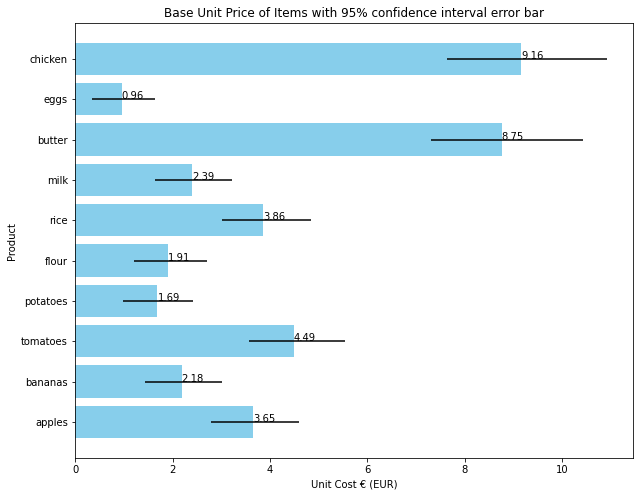

In [ ]:
#plotting base prices
plt.figure(figsize=(10,8))
plt.title('Base Unit Price of Items with 95% confidence interval error bar')
plt.barh(products, baseCosts[:,0],
         xerr = np.absolute(baseCosts[:, [2, 3]].T - np.stack((baseCosts[:, 0], baseCosts[:, 0]))), color = 'skyblue')
for i in range(len(products)):
    plt.annotate(np.around(baseCosts[:,0][i], 2), (baseCosts[:, 0][i], i))
plt.ylabel('Product')
plt.xlabel('Unit Cost € (EUR)')
plt.show()

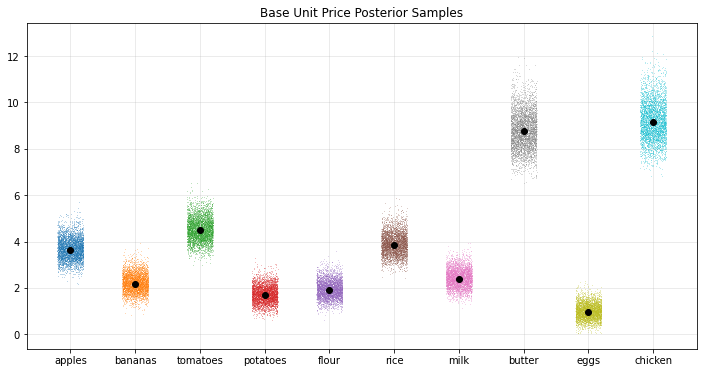

In [ ]:
plt.figure(figsize=(12,6))

for i in range(len(products)):
    plt.plot(sts.uniform.rvs(loc = i+0.8, scale = 0.4, size = 4000), 
             results['baseCosts'][:,i], 
             ',', alpha = 0.3)
    
    plt.plot(range(1, 1 + len(products))[i],
             results['baseCosts'][:,i].mean(axis=0),
             marker='o', color="black")

plt.title('Base Unit Price Posterior Samples')
plt.xticks(range(1, 1+ len(products)), list(products))
plt.show()

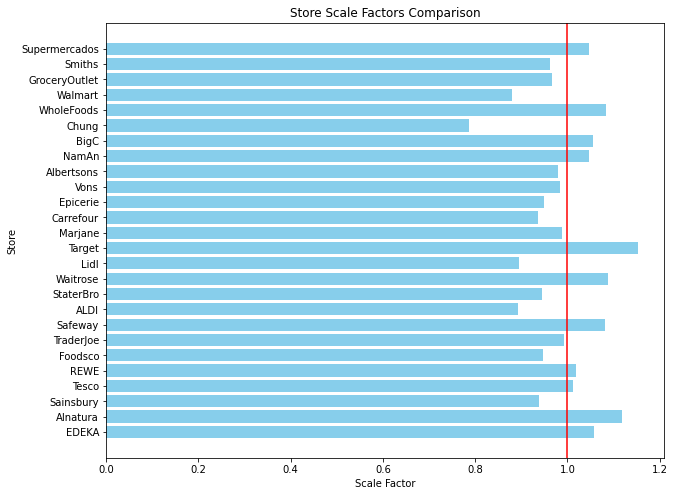

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Store Scale Factors Comparison')
plt.barh(stores, storeScales[:,0], color = 'skyblue')
plt.axvline(x = 1, color = 'red')
plt.xlabel('Scale Factor')
plt.ylabel('Store')
plt.show()

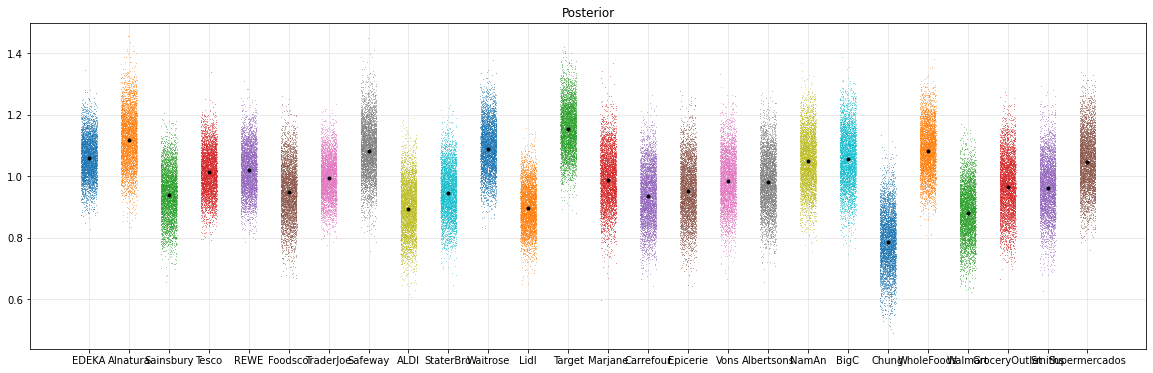

In [ ]:
plt.figure(figsize=(20,6))
for i in range(len(stores)):
    plt.plot(sts.uniform.rvs(loc = i+0.8, scale = 0.4, size = 4000), 
             results['scale_store'][:,i], 
             ',', alpha=0.5)
    plt.plot(range(1, 1 + len(list(new_df['Store Code'])))[i],
             results['scale_store'][:,i].mean(axis=0), 
             marker='.', color="black")
plt.title('Posterior')
plt.xticks(range(1, 1+ len(stores)),list(stores))
plt.show()

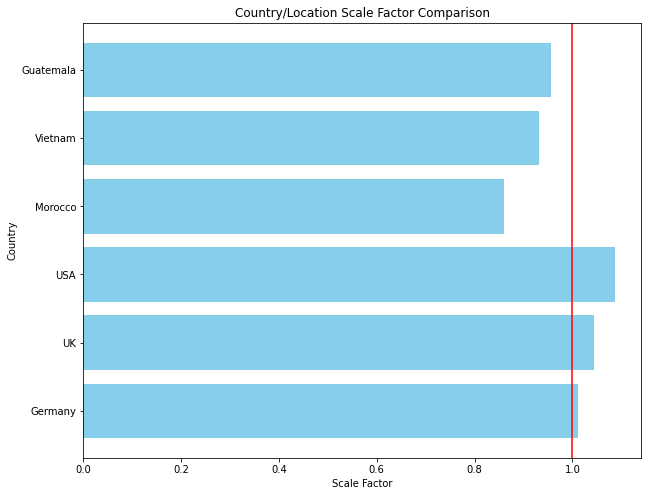

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Country/Location Scale Factor Comparison')
plt.barh(countries, countryScales[:,0], color = 'skyblue')
plt.axvline(x = 1, color='red')
plt.xlabel('Scale Factor')
plt.ylabel('Country')
plt.show()

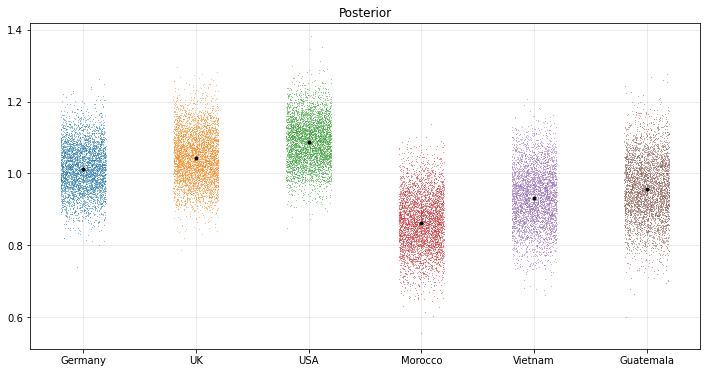

In [ ]:
plt.figure(figsize=(12,6))

for i in range(len(countries)):
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.4, size=4000), 
             results['scale_country'][:,i], 
             ',', alpha=0.5)
    plt.plot(range(1, 1 + len(list(new_df['Country Code'])))[i],
             results['scale_country'][:,i].mean(axis=0), 
         marker='.', color="black")

plt.title('Posterior')
plt.xticks(range(1, 1+ len(countries)), list(countries))

plt.show()

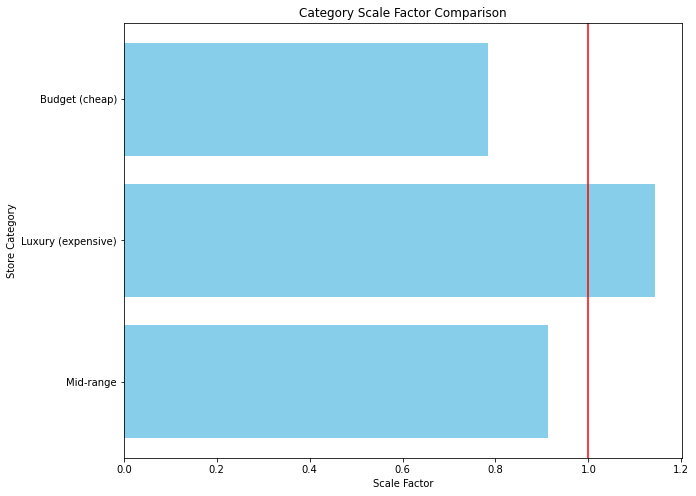

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Category Scale Factor Comparison')
plt.barh(categories, catScales[:,0], color = 'skyblue')
plt.axvline(x = 1, color='red')
plt.xlabel('Scale Factor')
plt.ylabel('Store Category')
plt.show()

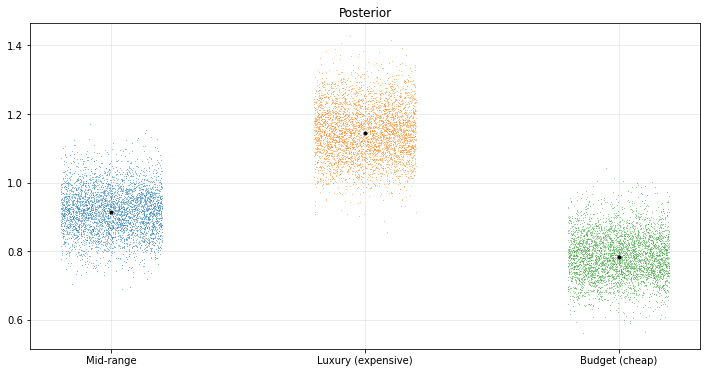

In [ ]:
plt.figure(figsize=(12,6))
for i in range(len(categories)):
    plt.plot(sts.uniform.rvs(loc=i+0.8, scale=0.4, size=4000), 
             results['scale_cat'][:,i], 
             ',', alpha=0.5)
    plt.plot(range(1, 1 + len(list(new_df['Category Code'])))[i],
             results['scale_cat'][:,i].mean(axis=0), 
         marker='.', color="black")
plt.title('Posterior')
plt.xticks(range(1, 1+ len(categories)), list(categories))

plt.show()

In [ ]:
countries

['Germany', 'UK', 'USA', 'Morocco', 'Vietnam', 'Guatemala']

In [ ]:
results['scale_country'][0,:]

array([1.00704234, 1.02415441, 0.92785525, 0.80915789, 0.91865688,
       0.93059544])

In [ ]:
#taking country wise average rents from collected data
rent = [947, 1872, 1652, 855, 703, 392]
rent = np.asarray(rent)
np.corrcoef(rent, results['scale_country'][0,:])

array([[1.       , 0.4314815],
       [0.4314815, 1.       ]])

In [ ]:
rent

array([ 947, 1872, 1652,  855,  703,  392])